# Segmentation map으로 도로 이미지 만들기

1. 데이터에 한 가지 이상의 augmentation 방법을 적용하여 학습해주세요. 


2. 이전에 구현했던 두 개의 Generator 중 Encoder와 Decoder간에 skip connection이 있는 U-Net Generator를 사용해주세요.  


3. 모델 학습 후, 학습된 Generator를 이용해 테스트합니다. 테스트 데이터는 다운받았던 "val" 폴더 내 이미지를 사용해주세요.  


4. 1개 이상의 이미지에 대해 테스트 과정을 거친 후 그 결과를 스케치, 생성된 사진, 실제 사진 순서로 나란히 시각화해 주세요.  


5. 모델을 충분히 학습하기에 시간이 부족할 수 있습니다. 적어도 10 epoch 이상 학습하며 중간 손실 값에 대한 로그를 남겨주세요. 좋은 결과를 얻기 위해선 긴 학습 시간이 필요하므로 테스트 결과는 만족스럽지 않아도 괜찮습니다.

In [1]:
import os

data_path = os.getenv('HOME')+'/aiffel/conditional_generation/cityscapes/train/'
print("number of train examples :", len(os.listdir(data_path)))

number of train examples : 1000


우선 train 폴더에는 1000개의 이미지가 있습니다.

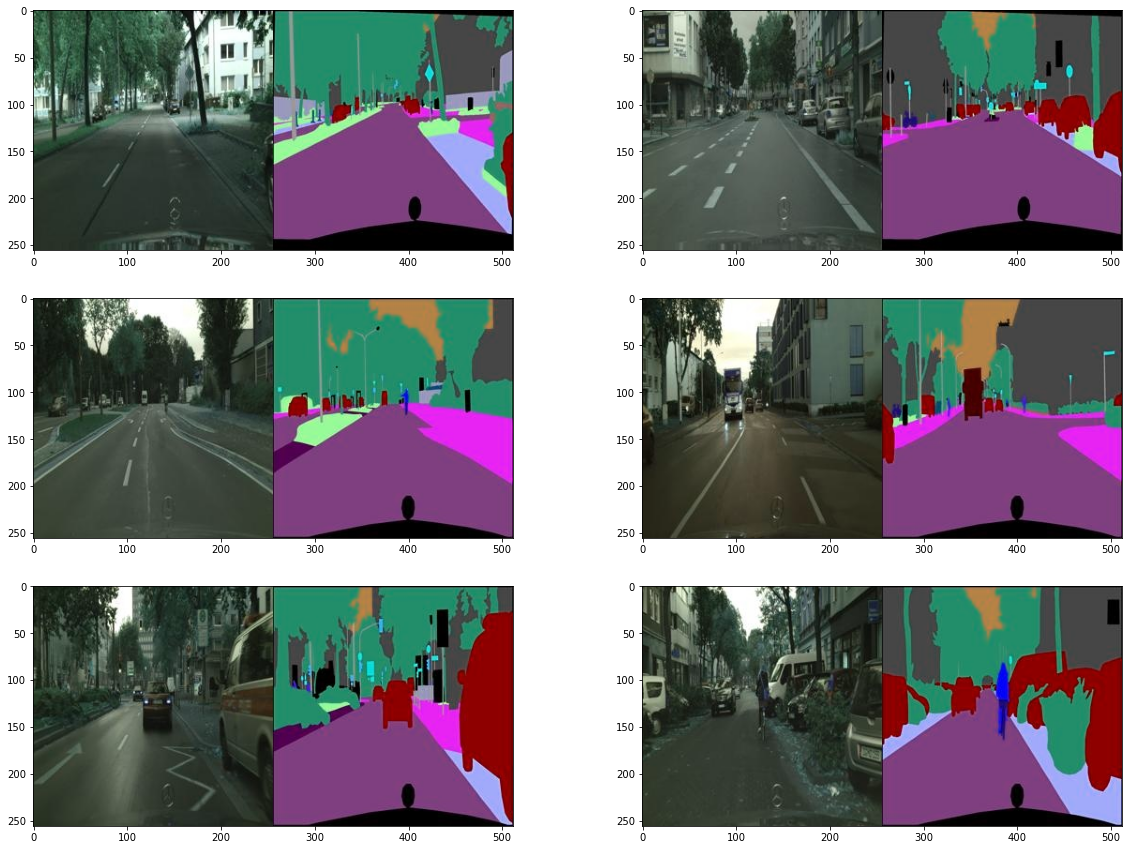

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(20,15))
for i in range(1, 7):
    f = data_path + os.listdir(data_path)[np.random.randint(800)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)

In [3]:
f = data_path + os.listdir(data_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


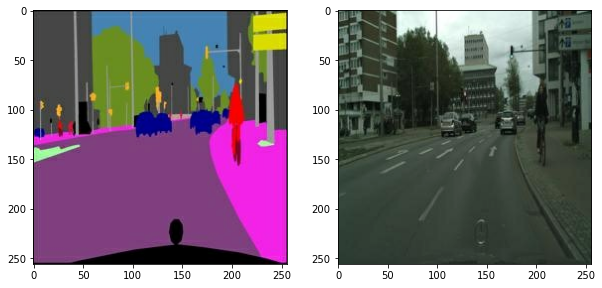

In [4]:
import tensorflow as tf

def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    colored = img[:, :w, :] 
    colored = tf.cast(colored, tf.float32)
    sketch = img[:, w:, :] 
    sketch = tf.cast(sketch, tf.float32)
    return normalize(sketch), normalize(colored)

f = data_path + os.listdir(data_path)[1]
sketch, colored = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(sketch))
plt.subplot(1,2,2); plt.imshow(denormalize(colored))

노드와는 좌우 위치가 다르길래 이 부분에서 colored와 sketch의 변수명을 바꿨다.  

다른 분들 결과를 보니 위치를 유지시킨 분들도 있던데 다른 부분의 return값 순서를 바꿨다(어딘지는 못찾았다)

In [5]:
from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation

@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용합니다. 
def apply_augmentation(sketch, colored):
    stacked = tf.concat([sketch, colored], axis=-1)
    
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)

    out = image.random_crop(padded, size=[256, 256, 6])
    
    out = image.random_flip_left_right(out)
    out = image.random_flip_up_down(out)
    
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)
    
    return out[...,:3], out[...,3:]   

print("✅")

✅


### Augmentation 진행

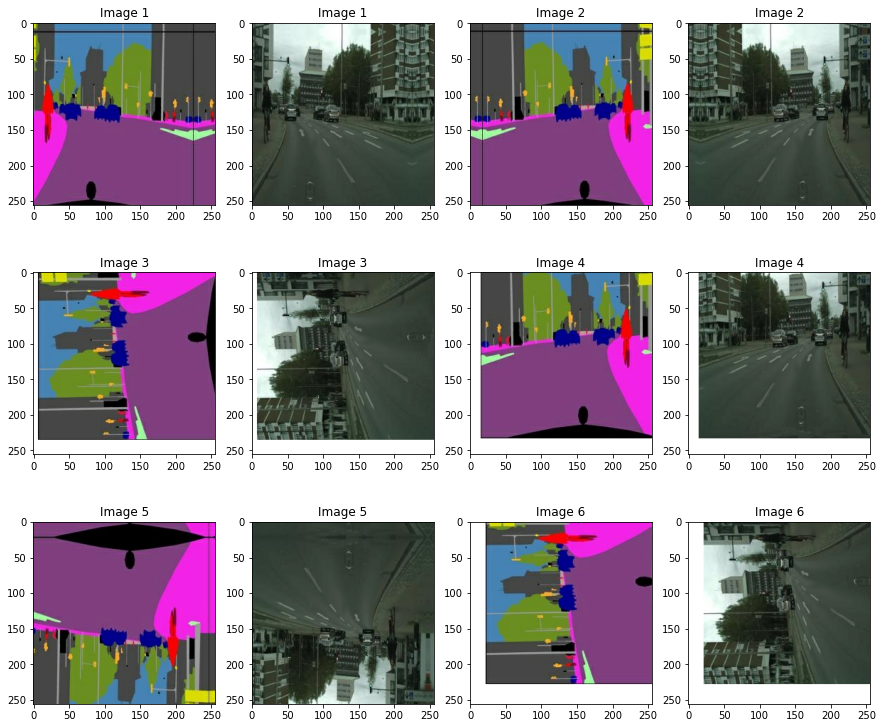

In [6]:
plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
    augmented_sketch, augmented_colored = apply_augmentation(sketch, colored)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_sketch)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_colored)); plt.title(f"Image {img_n}")
    img_n += 1

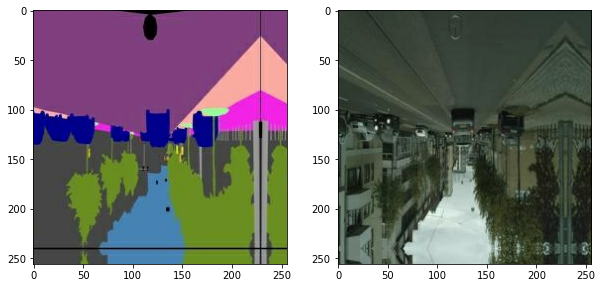

In [7]:
from tensorflow import data

def get_train(img_path):
    sketch, colored = load_img(img_path)
    sketch, colored = apply_augmentation(sketch, colored)
    return sketch, colored

train_images = data.Dataset.list_files(data_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
sketch, colored = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(sketch[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(colored[0].astype(np.uint8))

In [8]:
from tensorflow.keras import layers, Input, Model

class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu= layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

print("✅")

✅


In [9]:
class Encoder(layers.Layer):
    def __init__(self):
        super(Encoder, self).__init__()
        filters = [64,128,256,512,512,512,512,512]
        
        self.blocks = []
        for i, f in enumerate(filters):
            if i == 0:
                self.blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.blocks.append(EncodeBlock(f))
    
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
    
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

print("✅")

✅


In [10]:
Encoder().get_summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
encode_block (EncodeBlock)   (None, 128, 128, 64)      3072      
_________________________________________________________________
encode_block_1 (EncodeBlock) (None, 64, 64, 128)       131584    
_________________________________________________________________
encode_block_2 (EncodeBlock) (None, 32, 32, 256)       525312    
_________________________________________________________________
encode_block_3 (EncodeBlock) (None, 16, 16, 512)       2099200   
_________________________________________________________________
encode_block_4 (EncodeBlock) (None, 8, 8, 512)         4196352   
_________________________________________________________________
encode_block_5 (EncodeBlock) (None, 4, 4, 512)         419635

In [11]:
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

    
class Decoder(layers.Layer):
    def __init__(self):
        super(Decoder, self).__init__()
        filters = [512,512,512,512,256,128,64]
        
        self.blocks = []
        for i, f in enumerate(filters):
            if i < 3:
                self.blocks.append(DecodeBlock(f))
            else:
                self.blocks.append(DecodeBlock(f, dropout=False))
                
        self.blocks.append(layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False))
        
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
            
    def get_summary(self, input_shape=(1,1,256)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()
        
print("✅")

✅


In [12]:
Decoder().get_summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1, 1, 256)]       0         
_________________________________________________________________
decode_block (DecodeBlock)   (None, 2, 2, 512)         2099200   
_________________________________________________________________
decode_block_1 (DecodeBlock) (None, 4, 4, 512)         4196352   
_________________________________________________________________
decode_block_2 (DecodeBlock) (None, 8, 8, 512)         4196352   
_________________________________________________________________
decode_block_3 (DecodeBlock) (None, 16, 16, 512)       4196352   
_________________________________________________________________
decode_block_4 (DecodeBlock) (None, 32, 32, 256)       2098176   
_________________________________________________________________
decode_block_5 (DecodeBlock) (None, 64, 64, 128)       5248

### U-Net 구조

In [13]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

print("✅")

✅


In [14]:
UNetGenerator().get_summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
encode_block_8 (EncodeBlock)    (None, 128, 128, 64) 3072        input_3[0][0]                    
__________________________________________________________________________________________________
encode_block_9 (EncodeBlock)    (None, 64, 64, 128)  131584      encode_block_8[0][0]             
__________________________________________________________________________________________________
encode_block_10 (EncodeBlock)   (None, 32, 32, 256)  525312      encode_block_9[0][0]             
____________________________________________________________________________________________

In [15]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

print("✅")

✅


In [16]:
inputs = Input((128,128,32))
out = layers.ZeroPadding2D()(inputs)
out = layers.Conv2D(64, 4, 1, "valid", use_bias=False)(out)
out = layers.BatchNormalization()(out)
out = layers.LeakyReLU(0.2)(out)

Model(inputs, out).summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 128, 128, 32)]    0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 130, 130, 32)      0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 127, 127, 64)      32768     
_________________________________________________________________
batch_normalization_30 (Batc (None, 127, 127, 64)      256       
_________________________________________________________________
leaky_re_lu_16 (LeakyReLU)   (None, 127, 127, 64)      0         
Total params: 33,024
Trainable params: 32,896
Non-trainable params: 128
_________________________________________________________________


In [17]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")
        
        # filters = [64,128,256,512,1]
        # self.blocks = [layers.Concatenate()]
        # for i, f in enumerate(filters):
        #     self.blocks.append(DiscBlock(
        #         n_filters=f,
        #         strides=2 if i<3 else 1,
        #         custom_pad=False if i<3 else True,
        #         use_bn=False if i==0 and i==4 else True,
        #         act=True if i<4 else False
        #     ))
    
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()
    
print("✅")


✅


In [18]:
Discriminator().get_summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_7 (Concatenate)     (None, 256, 256, 6)  0           input_5[0][0]                    
                                                                 input_6[0][0]                    
__________________________________________________________________________________________________
disc_block (DiscBlock)          (None, 128, 128, 64) 6144        concatenate_7[0][0]        

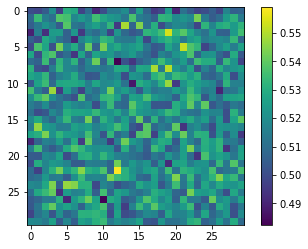

In [19]:
x = tf.random.normal([1,256,256,3])
y = tf.random.uniform([1,256,256,3])

disc_out = Discriminator()(x, y)
plt.imshow(disc_out[0, ... ,0])
plt.colorbar()

In [20]:
from tensorflow.keras import losses

bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

print("✅")

✅


In [21]:
from tensorflow.keras import optimizers

gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

print("✅")

✅


### 모델 학습 및 테스트

In [22]:
@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_colored = generator(sketch, training=True)
        # Discriminator 예측
        fake_disc = discriminator(sketch, fake_colored, training=True)
        real_disc = discriminator(sketch, real_colored, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

print("✅")

✅


In [23]:
EPOCHS = 40

generator = UNetGenerator()
discriminator = Discriminator()

for epoch in range(1, EPOCHS+1):
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sketch, colored)
                
        # 10회 반복마다 손실을 출력합니다.
        if (i+1) % 10 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[10]                     
Generator_loss:0.9495                     
L1_loss:0.3407                     
Discriminator_loss:1.2558

EPOCH[1] - STEP[20]                     
Generator_loss:1.0946                     
L1_loss:0.2663                     
Discriminator_loss:1.5887

EPOCH[1] - STEP[30]                     
Generator_loss:0.8037                     
L1_loss:0.2154                     
Discriminator_loss:1.9505

EPOCH[1] - STEP[40]                     
Generator_loss:0.8803                     
L1_loss:0.1889                     
Discriminator_loss:1.3152

EPOCH[1] - STEP[50]                     
Generator_loss:0.7855                     
L1_loss:0.1917                     
Discriminator_loss:1.1993

EPOCH[1] - STEP[60]                     
Generator_loss:1.0545                     
L1_loss:0.2281                     
Discriminator_loss:0.9999

EPOCH[1] - STEP[70]                     
Generator_loss:1.0298                     
L1_loss:0.1866                    

EPOCH[3] - STEP[70]                     
Generator_loss:1.9793                     
L1_loss:0.1555                     
Discriminator_loss:0.7004

EPOCH[3] - STEP[80]                     
Generator_loss:1.0802                     
L1_loss:0.1811                     
Discriminator_loss:0.7802

EPOCH[3] - STEP[90]                     
Generator_loss:1.6305                     
L1_loss:0.1734                     
Discriminator_loss:0.7274

EPOCH[3] - STEP[100]                     
Generator_loss:1.9724                     
L1_loss:0.1604                     
Discriminator_loss:0.7060

EPOCH[3] - STEP[110]                     
Generator_loss:2.4216                     
L1_loss:0.1947                     
Discriminator_loss:0.3637

EPOCH[3] - STEP[120]                     
Generator_loss:2.1793                     
L1_loss:0.1611                     
Discriminator_loss:1.1354

EPOCH[3] - STEP[130]                     
Generator_loss:0.8160                     
L1_loss:0.1817                

EPOCH[5] - STEP[130]                     
Generator_loss:1.8038                     
L1_loss:0.1697                     
Discriminator_loss:0.7150

EPOCH[5] - STEP[140]                     
Generator_loss:0.8669                     
L1_loss:0.1688                     
Discriminator_loss:0.7316

EPOCH[5] - STEP[150]                     
Generator_loss:0.4267                     
L1_loss:0.1980                     
Discriminator_loss:1.3430

EPOCH[5] - STEP[160]                     
Generator_loss:1.3162                     
L1_loss:0.1819                     
Discriminator_loss:1.1189

EPOCH[5] - STEP[170]                     
Generator_loss:1.7893                     
L1_loss:0.1784                     
Discriminator_loss:0.9392

EPOCH[5] - STEP[180]                     
Generator_loss:1.7624                     
L1_loss:0.2175                     
Discriminator_loss:0.7459

EPOCH[5] - STEP[190]                     
Generator_loss:1.2513                     
L1_loss:0.1655             

EPOCH[7] - STEP[190]                     
Generator_loss:2.8590                     
L1_loss:0.1660                     
Discriminator_loss:0.5610

EPOCH[7] - STEP[200]                     
Generator_loss:0.5743                     
L1_loss:0.1707                     
Discriminator_loss:1.3188

EPOCH[7] - STEP[210]                     
Generator_loss:1.1197                     
L1_loss:0.2107                     
Discriminator_loss:1.9577

EPOCH[7] - STEP[220]                     
Generator_loss:1.2502                     
L1_loss:0.1588                     
Discriminator_loss:1.2350

EPOCH[7] - STEP[230]                     
Generator_loss:1.6969                     
L1_loss:0.1989                     
Discriminator_loss:0.4230

EPOCH[7] - STEP[240]                     
Generator_loss:1.6737                     
L1_loss:0.1851                     
Discriminator_loss:0.9676

EPOCH[7] - STEP[250]                     
Generator_loss:0.9514                     
L1_loss:0.1726             

EPOCH[9] - STEP[250]                     
Generator_loss:1.4017                     
L1_loss:0.1732                     
Discriminator_loss:1.5478

EPOCH[10] - STEP[10]                     
Generator_loss:1.6603                     
L1_loss:0.1737                     
Discriminator_loss:1.2753

EPOCH[10] - STEP[20]                     
Generator_loss:1.0679                     
L1_loss:0.2045                     
Discriminator_loss:0.6035

EPOCH[10] - STEP[30]                     
Generator_loss:1.5449                     
L1_loss:0.1569                     
Discriminator_loss:1.7244

EPOCH[10] - STEP[40]                     
Generator_loss:0.5120                     
L1_loss:0.1591                     
Discriminator_loss:1.2236

EPOCH[10] - STEP[50]                     
Generator_loss:1.0711                     
L1_loss:0.1958                     
Discriminator_loss:0.7290

EPOCH[10] - STEP[60]                     
Generator_loss:1.4609                     
L1_loss:0.1468             

EPOCH[12] - STEP[60]                     
Generator_loss:3.0768                     
L1_loss:0.1642                     
Discriminator_loss:3.2456

EPOCH[12] - STEP[70]                     
Generator_loss:0.9000                     
L1_loss:0.1970                     
Discriminator_loss:0.6179

EPOCH[12] - STEP[80]                     
Generator_loss:1.6514                     
L1_loss:0.1651                     
Discriminator_loss:1.7662

EPOCH[12] - STEP[90]                     
Generator_loss:0.9652                     
L1_loss:0.2111                     
Discriminator_loss:0.6476

EPOCH[12] - STEP[100]                     
Generator_loss:2.3307                     
L1_loss:0.1329                     
Discriminator_loss:1.9481

EPOCH[12] - STEP[110]                     
Generator_loss:2.4748                     
L1_loss:0.1690                     
Discriminator_loss:0.6012

EPOCH[12] - STEP[120]                     
Generator_loss:2.0179                     
L1_loss:0.1813          

EPOCH[14] - STEP[120]                     
Generator_loss:2.5986                     
L1_loss:0.2025                     
Discriminator_loss:0.7810

EPOCH[14] - STEP[130]                     
Generator_loss:0.8184                     
L1_loss:0.1976                     
Discriminator_loss:0.6869

EPOCH[14] - STEP[140]                     
Generator_loss:1.3788                     
L1_loss:0.1815                     
Discriminator_loss:0.6441

EPOCH[14] - STEP[150]                     
Generator_loss:0.9100                     
L1_loss:0.1888                     
Discriminator_loss:1.9201

EPOCH[14] - STEP[160]                     
Generator_loss:1.7072                     
L1_loss:0.1501                     
Discriminator_loss:2.1907

EPOCH[14] - STEP[170]                     
Generator_loss:0.6397                     
L1_loss:0.1998                     
Discriminator_loss:0.9839

EPOCH[14] - STEP[180]                     
Generator_loss:2.9063                     
L1_loss:0.1602      

EPOCH[16] - STEP[180]                     
Generator_loss:0.8094                     
L1_loss:0.1649                     
Discriminator_loss:0.9447

EPOCH[16] - STEP[190]                     
Generator_loss:1.6830                     
L1_loss:0.1804                     
Discriminator_loss:0.4759

EPOCH[16] - STEP[200]                     
Generator_loss:1.4972                     
L1_loss:0.1497                     
Discriminator_loss:1.1041

EPOCH[16] - STEP[210]                     
Generator_loss:0.7637                     
L1_loss:0.1900                     
Discriminator_loss:0.7582

EPOCH[16] - STEP[220]                     
Generator_loss:1.8268                     
L1_loss:0.1980                     
Discriminator_loss:0.3097

EPOCH[16] - STEP[230]                     
Generator_loss:0.8251                     
L1_loss:0.1769                     
Discriminator_loss:1.2513

EPOCH[16] - STEP[240]                     
Generator_loss:1.9691                     
L1_loss:0.1790      

EPOCH[18] - STEP[240]                     
Generator_loss:2.3321                     
L1_loss:0.1726                     
Discriminator_loss:1.2005

EPOCH[18] - STEP[250]                     
Generator_loss:1.2124                     
L1_loss:0.1611                     
Discriminator_loss:1.2196

EPOCH[19] - STEP[10]                     
Generator_loss:1.4093                     
L1_loss:0.1652                     
Discriminator_loss:0.4825

EPOCH[19] - STEP[20]                     
Generator_loss:1.6254                     
L1_loss:0.1786                     
Discriminator_loss:1.0051

EPOCH[19] - STEP[30]                     
Generator_loss:1.1417                     
L1_loss:0.1889                     
Discriminator_loss:0.5186

EPOCH[19] - STEP[40]                     
Generator_loss:1.2546                     
L1_loss:0.1819                     
Discriminator_loss:0.5090

EPOCH[19] - STEP[50]                     
Generator_loss:0.8703                     
L1_loss:0.1631           

EPOCH[21] - STEP[50]                     
Generator_loss:2.0996                     
L1_loss:0.1889                     
Discriminator_loss:0.4265

EPOCH[21] - STEP[60]                     
Generator_loss:1.3035                     
L1_loss:0.1939                     
Discriminator_loss:0.5352

EPOCH[21] - STEP[70]                     
Generator_loss:0.9325                     
L1_loss:0.2092                     
Discriminator_loss:0.6602

EPOCH[21] - STEP[80]                     
Generator_loss:0.3437                     
L1_loss:0.1852                     
Discriminator_loss:1.4216

EPOCH[21] - STEP[90]                     
Generator_loss:2.2380                     
L1_loss:0.1518                     
Discriminator_loss:0.8688

EPOCH[21] - STEP[100]                     
Generator_loss:2.5556                     
L1_loss:0.1867                     
Discriminator_loss:0.8313

EPOCH[21] - STEP[110]                     
Generator_loss:1.6299                     
L1_loss:0.1684           

EPOCH[23] - STEP[110]                     
Generator_loss:0.4750                     
L1_loss:0.1795                     
Discriminator_loss:1.1123

EPOCH[23] - STEP[120]                     
Generator_loss:1.6278                     
L1_loss:0.1877                     
Discriminator_loss:0.5158

EPOCH[23] - STEP[130]                     
Generator_loss:1.0274                     
L1_loss:0.1879                     
Discriminator_loss:0.6600

EPOCH[23] - STEP[140]                     
Generator_loss:1.2056                     
L1_loss:0.1725                     
Discriminator_loss:0.6032

EPOCH[23] - STEP[150]                     
Generator_loss:2.5291                     
L1_loss:0.1904                     
Discriminator_loss:0.1518

EPOCH[23] - STEP[160]                     
Generator_loss:1.8777                     
L1_loss:0.1819                     
Discriminator_loss:0.4080

EPOCH[23] - STEP[170]                     
Generator_loss:1.6238                     
L1_loss:0.1878      

EPOCH[25] - STEP[170]                     
Generator_loss:2.2126                     
L1_loss:0.1600                     
Discriminator_loss:0.6254

EPOCH[25] - STEP[180]                     
Generator_loss:0.8203                     
L1_loss:0.1524                     
Discriminator_loss:1.2445

EPOCH[25] - STEP[190]                     
Generator_loss:0.0708                     
L1_loss:0.1934                     
Discriminator_loss:2.9812

EPOCH[25] - STEP[200]                     
Generator_loss:0.4833                     
L1_loss:0.1995                     
Discriminator_loss:1.0648

EPOCH[25] - STEP[210]                     
Generator_loss:0.6694                     
L1_loss:0.1661                     
Discriminator_loss:1.1664

EPOCH[25] - STEP[220]                     
Generator_loss:1.0928                     
L1_loss:0.1725                     
Discriminator_loss:0.7660

EPOCH[25] - STEP[230]                     
Generator_loss:2.7059                     
L1_loss:0.1488      

EPOCH[27] - STEP[230]                     
Generator_loss:0.2927                     
L1_loss:0.1943                     
Discriminator_loss:1.4930

EPOCH[27] - STEP[240]                     
Generator_loss:2.3019                     
L1_loss:0.1417                     
Discriminator_loss:1.9083

EPOCH[27] - STEP[250]                     
Generator_loss:0.8681                     
L1_loss:0.1896                     
Discriminator_loss:0.6871

EPOCH[28] - STEP[10]                     
Generator_loss:1.7398                     
L1_loss:0.1669                     
Discriminator_loss:0.5510

EPOCH[28] - STEP[20]                     
Generator_loss:1.4423                     
L1_loss:0.1671                     
Discriminator_loss:1.8866

EPOCH[28] - STEP[30]                     
Generator_loss:1.6909                     
L1_loss:0.1904                     
Discriminator_loss:0.5676

EPOCH[28] - STEP[40]                     
Generator_loss:1.0427                     
L1_loss:0.1502          

EPOCH[30] - STEP[40]                     
Generator_loss:0.5558                     
L1_loss:0.1736                     
Discriminator_loss:1.1440

EPOCH[30] - STEP[50]                     
Generator_loss:1.1851                     
L1_loss:0.2129                     
Discriminator_loss:0.4630

EPOCH[30] - STEP[60]                     
Generator_loss:0.2873                     
L1_loss:0.1655                     
Discriminator_loss:1.6119

EPOCH[30] - STEP[70]                     
Generator_loss:1.3441                     
L1_loss:0.1862                     
Discriminator_loss:0.3757

EPOCH[30] - STEP[80]                     
Generator_loss:1.3152                     
L1_loss:0.1900                     
Discriminator_loss:0.3712

EPOCH[30] - STEP[90]                     
Generator_loss:0.8346                     
L1_loss:0.1725                     
Discriminator_loss:0.7868

EPOCH[30] - STEP[100]                     
Generator_loss:1.9525                     
L1_loss:0.1715            

EPOCH[32] - STEP[100]                     
Generator_loss:1.0024                     
L1_loss:0.1600                     
Discriminator_loss:0.6116

EPOCH[32] - STEP[110]                     
Generator_loss:2.2906                     
L1_loss:0.1858                     
Discriminator_loss:0.7674

EPOCH[32] - STEP[120]                     
Generator_loss:1.5326                     
L1_loss:0.1567                     
Discriminator_loss:0.8391

EPOCH[32] - STEP[130]                     
Generator_loss:1.0832                     
L1_loss:0.1635                     
Discriminator_loss:1.6194

EPOCH[32] - STEP[140]                     
Generator_loss:0.5302                     
L1_loss:0.1888                     
Discriminator_loss:1.0977

EPOCH[32] - STEP[150]                     
Generator_loss:1.1664                     
L1_loss:0.1626                     
Discriminator_loss:0.9309

EPOCH[32] - STEP[160]                     
Generator_loss:0.8638                     
L1_loss:0.1633      

EPOCH[34] - STEP[160]                     
Generator_loss:2.1045                     
L1_loss:0.1846                     
Discriminator_loss:0.7813

EPOCH[34] - STEP[170]                     
Generator_loss:1.0788                     
L1_loss:0.1905                     
Discriminator_loss:1.0526

EPOCH[34] - STEP[180]                     
Generator_loss:1.1691                     
L1_loss:0.1525                     
Discriminator_loss:0.8222

EPOCH[34] - STEP[190]                     
Generator_loss:1.7391                     
L1_loss:0.1634                     
Discriminator_loss:1.0077

EPOCH[34] - STEP[200]                     
Generator_loss:0.7566                     
L1_loss:0.1969                     
Discriminator_loss:0.7446

EPOCH[34] - STEP[210]                     
Generator_loss:1.0548                     
L1_loss:0.1564                     
Discriminator_loss:0.9192

EPOCH[34] - STEP[220]                     
Generator_loss:1.3233                     
L1_loss:0.1582      

EPOCH[36] - STEP[220]                     
Generator_loss:2.2987                     
L1_loss:0.1678                     
Discriminator_loss:0.9612

EPOCH[36] - STEP[230]                     
Generator_loss:1.4710                     
L1_loss:0.2170                     
Discriminator_loss:0.2980

EPOCH[36] - STEP[240]                     
Generator_loss:1.4729                     
L1_loss:0.1805                     
Discriminator_loss:0.3905

EPOCH[36] - STEP[250]                     
Generator_loss:1.4971                     
L1_loss:0.2023                     
Discriminator_loss:0.3940

EPOCH[37] - STEP[10]                     
Generator_loss:0.8244                     
L1_loss:0.1704                     
Discriminator_loss:0.8367

EPOCH[37] - STEP[20]                     
Generator_loss:1.1254                     
L1_loss:0.1576                     
Discriminator_loss:0.7103

EPOCH[37] - STEP[30]                     
Generator_loss:1.8610                     
L1_loss:0.1657         

EPOCH[39] - STEP[30]                     
Generator_loss:1.3635                     
L1_loss:0.1698                     
Discriminator_loss:0.7831

EPOCH[39] - STEP[40]                     
Generator_loss:1.0475                     
L1_loss:0.2038                     
Discriminator_loss:0.5502

EPOCH[39] - STEP[50]                     
Generator_loss:1.4406                     
L1_loss:0.1424                     
Discriminator_loss:1.2670

EPOCH[39] - STEP[60]                     
Generator_loss:1.7877                     
L1_loss:0.1944                     
Discriminator_loss:0.3511

EPOCH[39] - STEP[70]                     
Generator_loss:0.9306                     
L1_loss:0.1835                     
Discriminator_loss:0.8969

EPOCH[39] - STEP[80]                     
Generator_loss:1.1575                     
L1_loss:0.1767                     
Discriminator_loss:1.1486

EPOCH[39] - STEP[90]                     
Generator_loss:1.8329                     
L1_loss:0.2340             

### 시각화

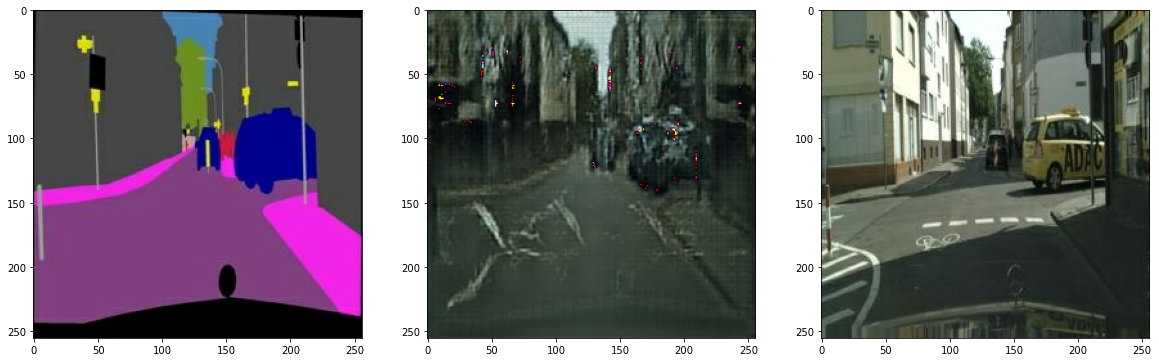

In [34]:
test_ind = 0
data_path = os.getenv('HOME')+'/aiffel/conditional_generation/cityscapes/val/'

f = data_path + os.listdir(data_path)[test_ind]
sketch, colored = load_img(f)

pred = generator(tf.expand_dims(sketch, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(denormalize(sketch))
plt.subplot(1,3,2); plt.imshow(pred[0])
plt.subplot(1,3,3); plt.imshow(denormalize(colored))